<b>Vorstellung Datensatz</b><br>
Dieser Datensatz enthält Informationen über verschiedene Attribute einer Reihe von Früchten, die Aufschluss über deren Eigenschaften geben. Der Datensatz <br>
enthält Details wie Frucht-ID, Größe, Gewicht, Süße, Knackigkeit, Saftigkeit, Reifegrad, Säuregehalt und Qualität.<sup>1</sup><br> <br>
1: A_id: Unique identifier for each fruit <br>
2: Size: Size of the fruit<br>
3: Weight: Weight of the fruit<br>
4: Sweetness: Degree of sweetness of the fruit<br>
5: Crunchiness: Texture indicating the crunchiness of the fruit<br>
6: Juiciness: Level of juiciness of the fruit<br>
7: Ripeness: Stage of ripeness of the fruit<br>
8: Acidity: Acidity level of the fruit<br>
9: Quality: Overall quality of the fruit<br>

Eine Recherche zu dem Datensatz hat ergeben, dass sich die Daten auf einen Standard Apfel beziehen und somit keine Werte in einer SI Einheit darstellen. Nach dem Bundeszentrum für Ernährung<br>
muss ein Apfel in Europa eine Mindestgröße von 60 Milimeter im Durchmesser aufweisen und ein Mindestgewicht von 90 Gramm haben.<sup>2</sup> Somit wird bei einem Wert von über Null von einem über <br>
dem Standard liegenden Apfel ausgegangen und bei einem Wert unter Null somit von einem Apfel unter den Standard Maßen. <br>
Der Apfelstandard der USA ist wie folgt:<sup>3</sup> <br><br>
<img src="../images/AppleStandard.png"><br>
<sub>Abbildung 1 Apfelstandard USA</sub><br><br>
<b>Quelle</b><br>
<sup>1</sup> https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality/data<br>
<sup>2</sup> https://www.bzfe.de/lebensmittel/vom-acker-bis-zum-teller/aepfel/aepfel-einkauf-und-kennzeichnung/#:~:text=Qualität%2C%20Form%20und%20Größe%20entscheiden,wenn%20sie%20ausreichend%20reif%20sind.<br>
<sup>3</sup> https://www.ams.usda.gov/sites/default/files/media/Apple_Standards.pdf<br>


In [23]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [9]:
# Functions 

# Function to find records with outliers (4)
def find_outliers_pandas(data, column):
	Q1 = data[column].quantile(0.25)
	Q3 = data[column].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
	return outliers

# Scatter Plot Function
def plot_scatter(df,x_axis,y_axis):
    good = df[df['Quality'] == 'good']
    bad = df[df['Quality'] == 'bad']
    
    plt.scatter(good[x_axis], good[y_axis], color='green', label='Good', s=5)
    plt.scatter(bad[x_axis], bad[y_axis], color='orange', label='Bad', s=5)
    
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(f'Scatter Plot: {x_axis} vs {y_axis}')
    
    plt.legend()
    plt.show()

# Quelle
# (4) https://www.kdnuggets.com/7-essential-data-quality-checks-with-pandas

In [10]:
# Load the data
df = pd.read_csv('../data/apple_quality.csv', sep=',', header=0)
df = df.drop(columns=['A_id'])

<b>Characterization of the data set </b>

In [11]:
# Exploratory Data Analysis

# 1 Overall Overviwew
print('Head: \n',df.head())
# 2 Data Summary
print('\nSize: \n',df.shape)
# 3 Data Info
print('\nData Info: \n')
print(df.info())
# 4 Data Description
print('\nData Description: \n')
print(df.describe())
# 5 Missing Values
print('\nMissing Values: \n')
print(df.isnull().sum())

# Find records with outliers for each specified column (5) 
outliers_dict = {}

columns_to_check = df.columns[0:7]
for column in columns_to_check:
	outliers_dict[column] = find_outliers_pandas(df, column)
 
# Print the records with outliers for each column
for column, outliers in outliers_dict.items():
	print(f"Outliers in '{column}':")
	print(outliers)
	print("\n")

# Correlation Matrix
df_corr = df.drop(columns=['Quality'])
correlation_matrix = df_corr.corr()
print('Correlation Matrix: \n')
print(correlation_matrix)

# Quelle
# (5) https://www.kdnuggets.com/7-essential-data-quality-checks-with-pandas

Head: 
        Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

  Quality  
0    good  
1    good  
2     bad  
3    good  
4    good  

Size: 
 (4000, 8)

Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   R

In [12]:
# Filter expressions for exploring the data
lower_value = -0.1
higher_value = 0.1
column = 'Size'

filtered = df[(df[column] < higher_value) & (df[column] > lower_value)].reset_index(drop=True)
filtered

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-0.074370,-4.714750,0.249768,2.935319,1.409755,-2.643810,1.250970,good
1,-0.034368,-1.332805,2.329101,2.862759,0.825239,1.062672,2.300331,good
2,0.033471,-0.044161,-0.481202,4.937210,-0.609873,-3.231504,1.248792,good
3,0.039414,-1.137430,0.477732,1.656481,-3.256232,-0.503584,0.528699,bad
4,0.097398,-2.090140,-5.018889,0.173397,1.524662,5.278448,-1.700396,bad
...,...,...,...,...,...,...,...,...
154,-0.079753,2.682220,-1.480885,-1.592385,0.173402,-0.016318,1.933061,good
155,0.047628,-2.035774,-1.706659,1.760040,1.669244,1.843260,2.753851,bad
156,0.020965,-1.721253,0.328115,1.478052,1.056150,-0.200007,1.165777,bad
157,-0.027799,-1.356070,0.597772,1.252840,-1.418434,2.632352,2.000125,good


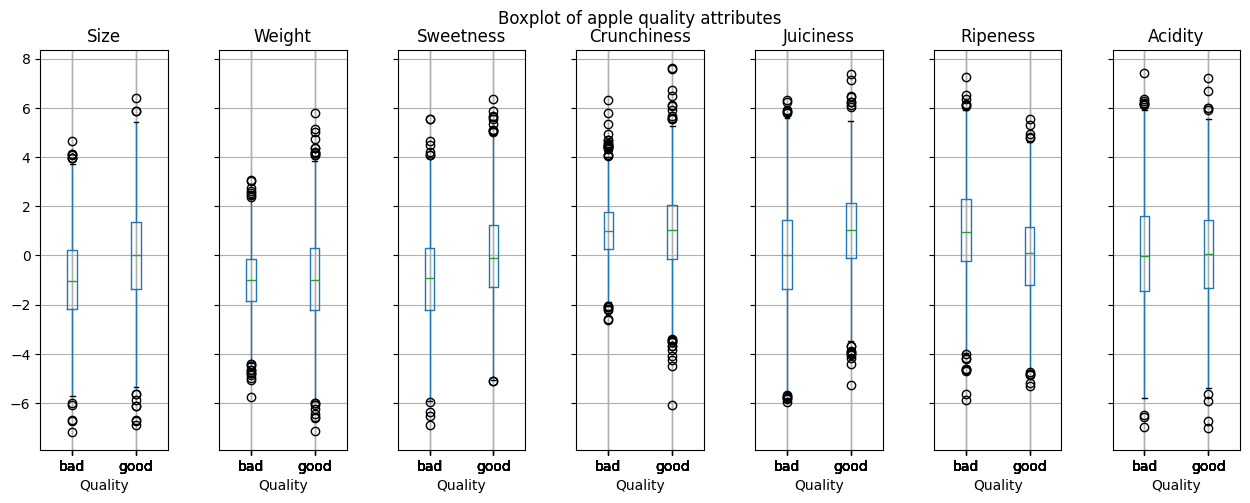

In [13]:
# Boxplot of apple quality attributes in relation to the quality
df.boxplot(column=['Size', 
                   'Weight', 
                   'Sweetness', 
                   'Crunchiness', 
                   'Juiciness', 
                   'Ripeness', 
                   'Acidity'], 
           by='Quality', 
           layout=(1, 7), 
           figsize=(15, 5))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

plt.suptitle('Boxplot of apple quality attributes')

plt.show()

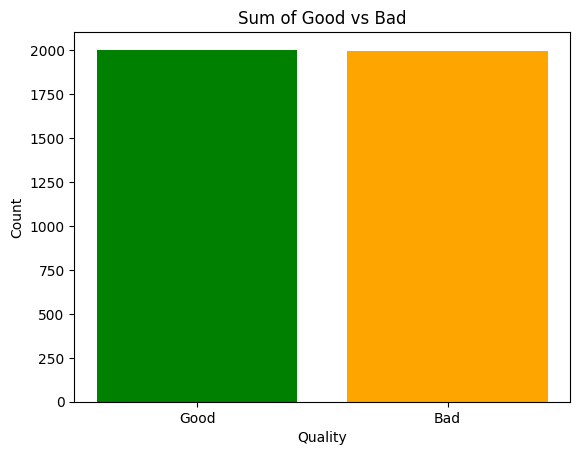

In [14]:
# Calculate the sum of "good" and "bad" values

good_count = df[df['Quality'] == 'good'].shape[0]
bad_count = df[df['Quality'] == 'bad'].shape[0]

# Create a bar chart
plt.bar(['Good', 'Bad'], [good_count, bad_count], color=['green', 'orange'])

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Sum of Good vs Bad')

# Display the chart
plt.show()

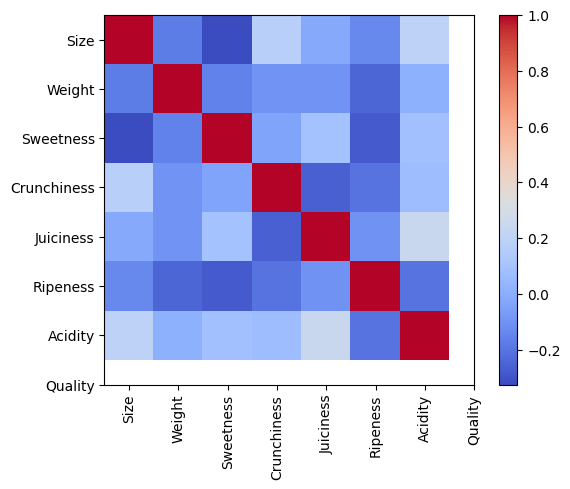

In [15]:
# Create a heatmap
plt.imshow(df_corr.corr(), cmap='coolwarm')

# Add colorbar
plt.colorbar()

# Set x-axis and y-axis labels
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)

# Show the plot
plt.show()

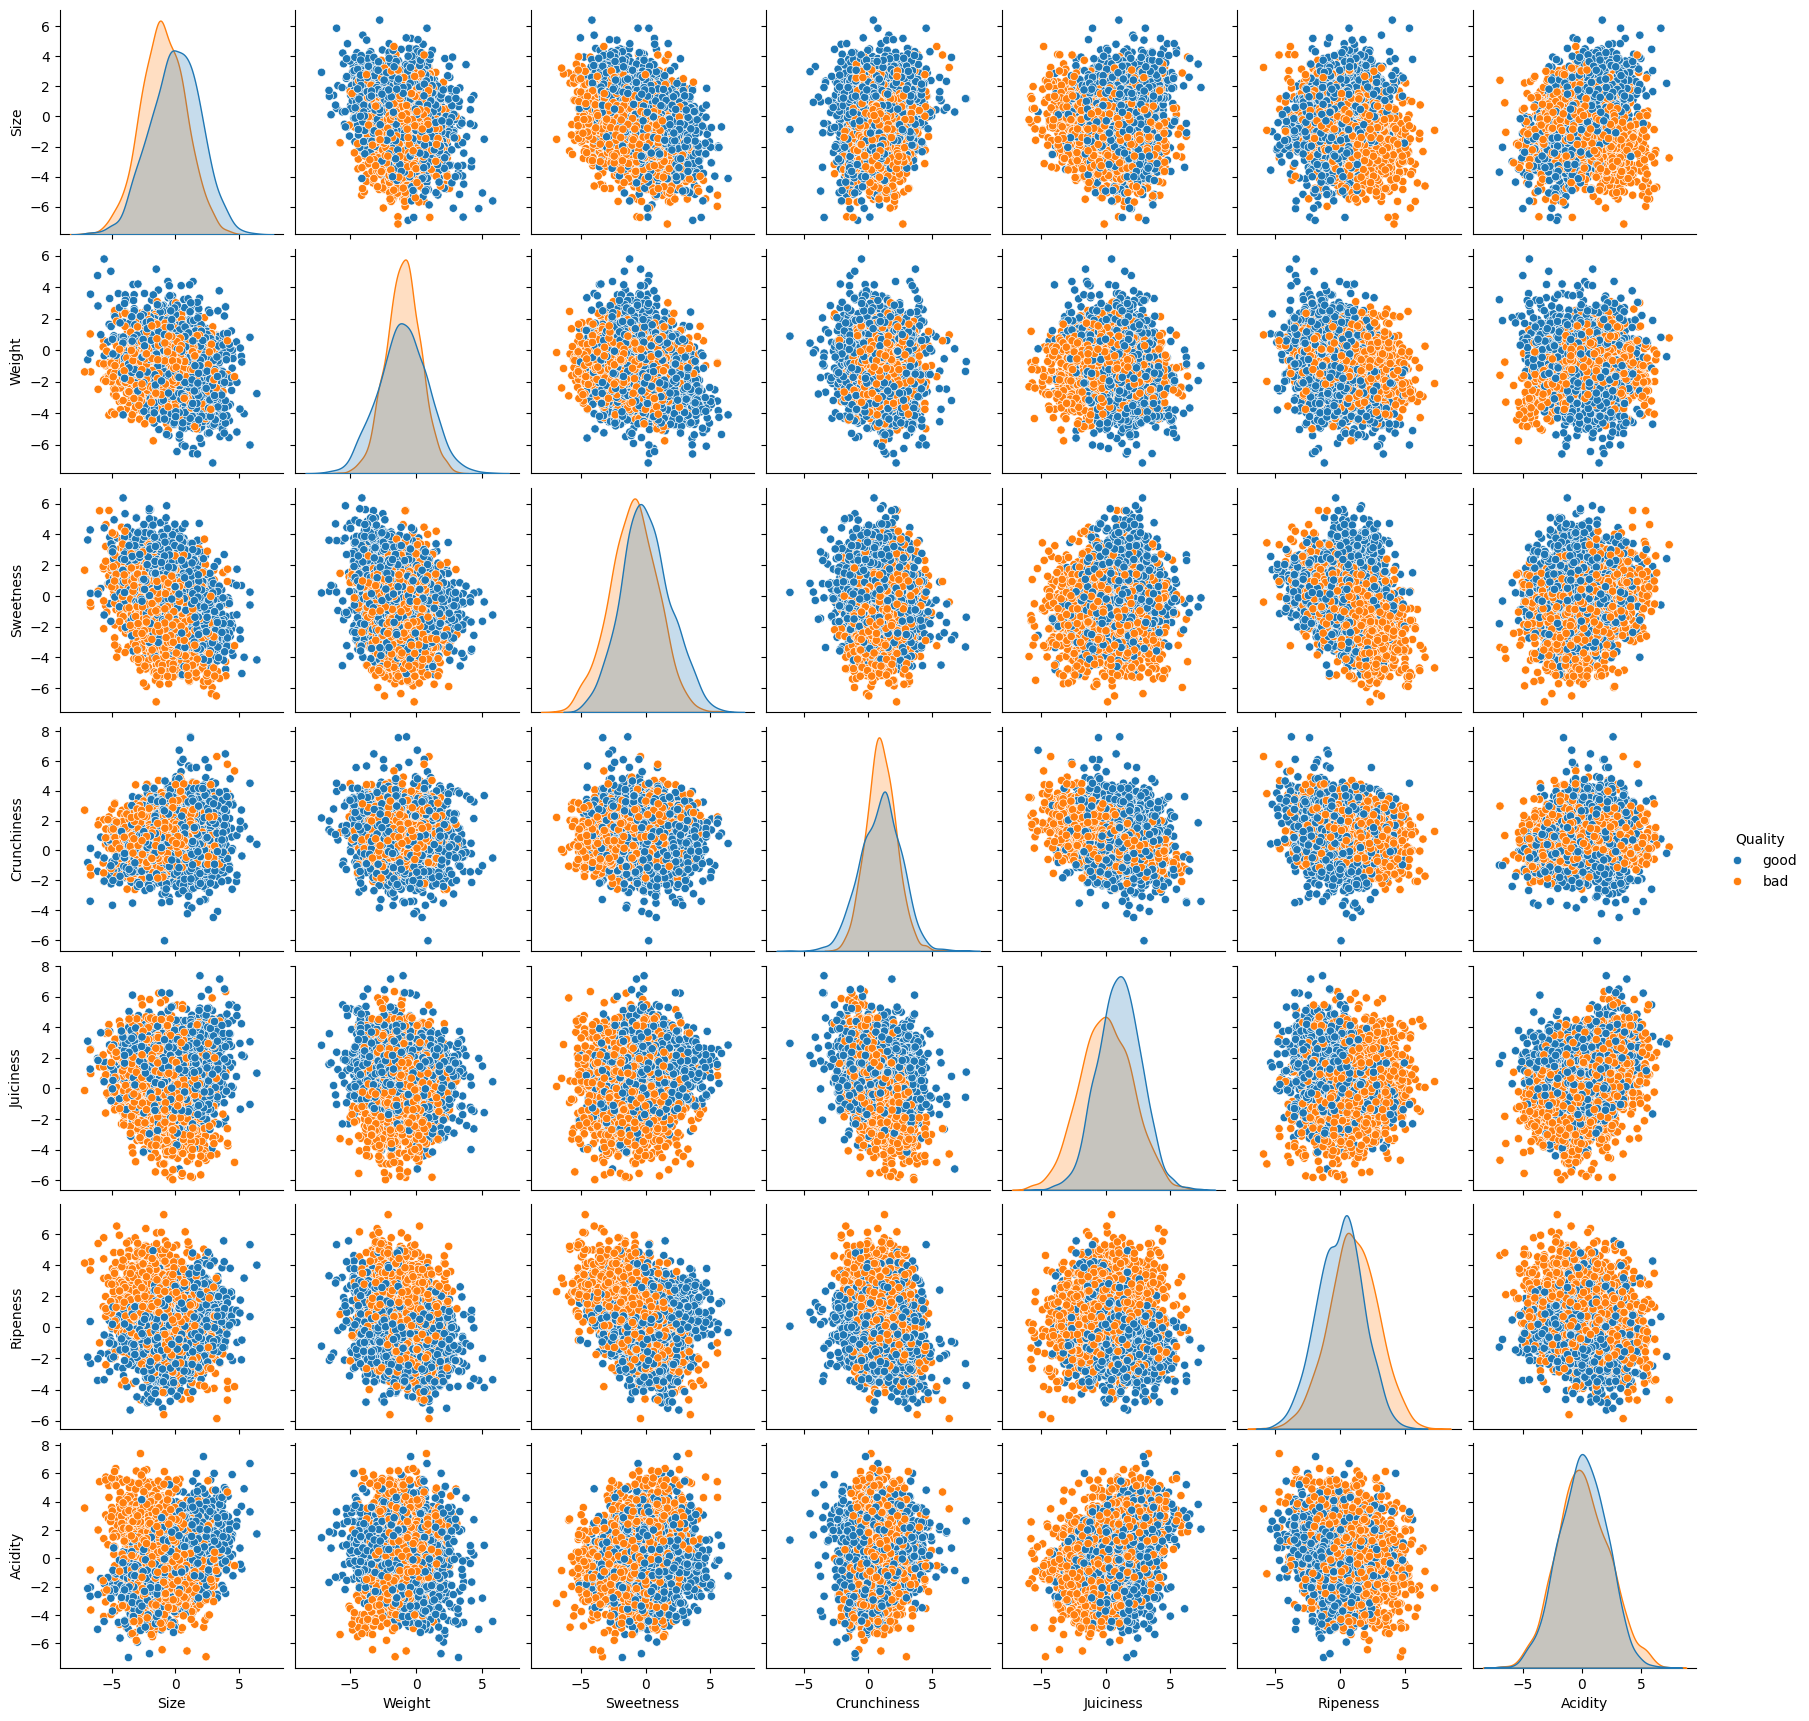

In [16]:
# Pairplot
sns.pairplot(df, hue='Quality')

In [20]:
# Desicion Tree
cols = df.columns[0:7]

clf1 = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf1.fit(df[cols], df['Quality'])

DecisionTreeClassifier(max_depth=5, random_state=42)

In [24]:
# make sklearn classification report
y_pred = clf1.predict(df[cols])
print(classification_report(df['Quality'], y_pred, target_names=df['Quality'].unique()))

              precision    recall  f1-score   support

        good       0.73      0.85      0.78      1996
         bad       0.82      0.68      0.74      2004

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.76      4000
weighted avg       0.77      0.77      0.76      4000



In [36]:
# print importance of features
for i in range(len(cols)):
    print("{}\t{:.2f}".format(cols[i], clf1.feature_importances_[i]))
    # print("{}\t{:.2f}".format(cols[1], clf1.feature_importances_[1]))

Size	0.22
Weight	0.11
Sweetness	0.13
Crunchiness	0.01
Juiciness	0.19
Ripeness	0.20
Acidity	0.13


In [22]:
# show decision tree as png
tree.export_graphviz(
            clf1,
            out_file =  "myTreeName.dot",
            feature_names = list(cols),
            filled = True,
            rounded = True,
            class_names = df['Quality'].unique())

# convert .dot to .png
from subprocess import call
call(['dot', '-Tpng', 'myTreeName.dot', '-o', 'myTreeName.png', '-Gdpi=600'])

# show the image
Image(filename = 'myTreeName.png', width=800)

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

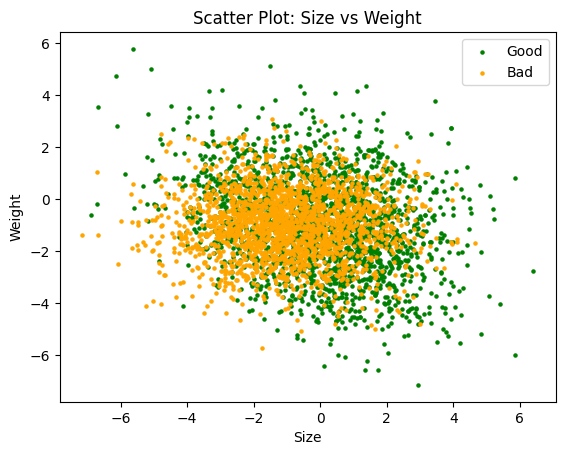

In [11]:
# Scatter plot of Size vs Weight

plot_scatter(df,'Size','Weight')


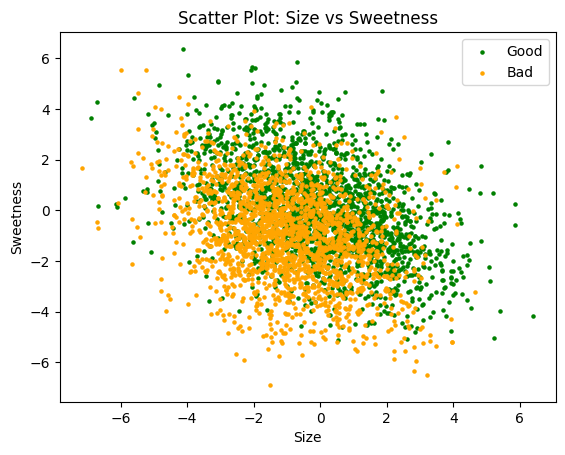

In [12]:
# Scatter plot of Size vs Sweetness

plot_scatter(df,'Size','Sweetness')

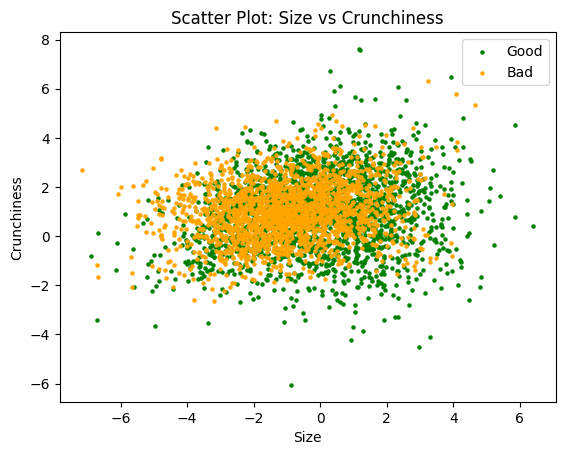

In [13]:
# Scatter plot of Size vs Crunchiness

plot_scatter(df,'Size','Crunchiness')

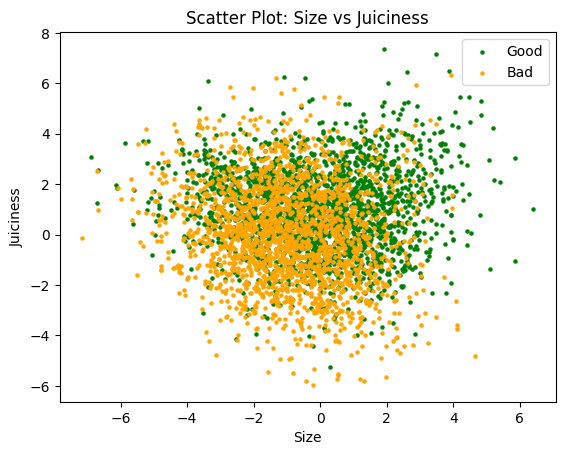

In [14]:
# Scatter plot of Size vs Juiciness

plot_scatter(df,'Size','Juiciness')

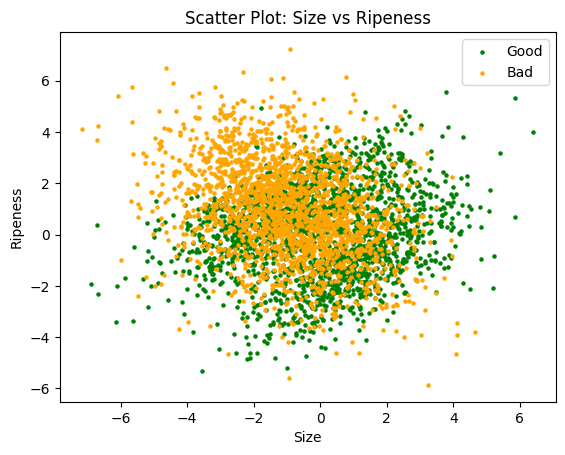

In [15]:
# Scatter plot of Size vs Ripeness

plot_scatter(df,'Size','Ripeness')

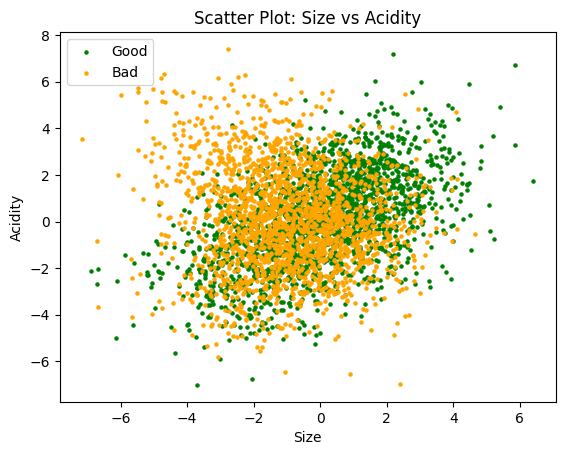

In [16]:
# Scatter plot of Size vs Acidity

plot_scatter(df,'Size','Acidity')

<b>Feature Engineering</b>

Principle Componen Analysis
https://www.youtube.com/watch?v=kApPBm1YsqU

In [17]:
# Principal Component Analysis (PCA) and standardization of data
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]    # Zielvariable

# Standardization of data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled:\n',X_scaled)
# PCA processing
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)
print('\nFitted:\n',X_pca)

Scaled:
 [[-1.79842417 -0.95037339  2.99342063 ...  0.69054495 -0.08987211
  -0.26941526]
 [-0.35906018 -1.15440431  2.12769769 ...  0.17676683  0.1970196
  -0.37899737]
 [ 0.1094454  -0.22575916 -0.65250727 ...  1.20542179 -0.28615565
   1.20604367]
 ...
 [-1.1056547  -0.71690397 -1.01378401 ...  0.87437918  2.27595716
  -0.66895013]
 [-1.81811235 -0.49290842  1.45990059 ...  0.85454883 -0.15141937
  -1.09317096]
 [ 0.40540882 -0.45307081  0.30449592 ...  0.39095445 -0.68021237
   0.72176064]]

Fitted:
 [[ 0.5644979   3.43601677]
 [ 0.40730266  1.0238054 ]
 [ 0.91396535  0.36102395]
 ...
 [-2.08277548  0.74755037]
 [-0.21851226  2.59325988]
 [ 0.86855657  0.66020537]]


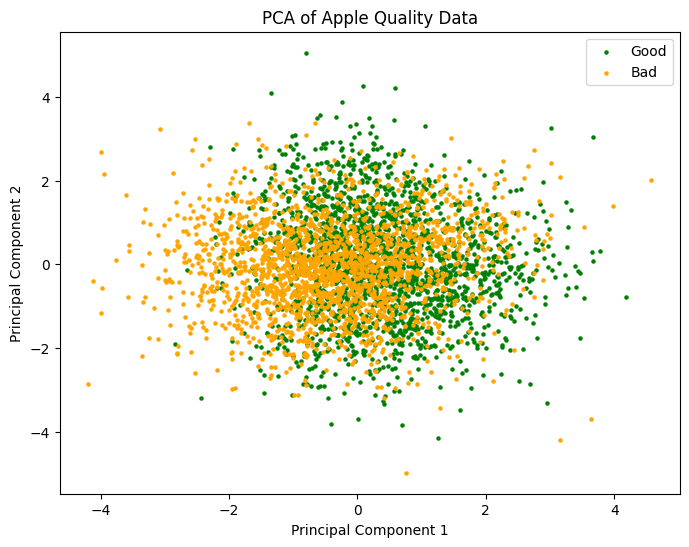

In [18]:
# Visualization of the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y=='good', 0], X_pca[y=='good', 1], color='green', label='Good', s=5)
plt.scatter(X_pca[y=='bad', 0], X_pca[y=='bad', 1], color='orange', label='Bad', s=5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Apple Quality Data')
plt.legend()
plt.show()